In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import odeint, solve_ivp, complex_ode
from numba import int64
from numba import int32

import fourier as ft
from sim_handling import Simulation

import diffusionstuff10 as ds

#for 3d plots
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D

#for saving animations
# import pickle
# from matplotlib import animation
# from IPython.display import HTML


In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 11
fontsize = 15
linewidth = 2

#  testing transform

In [3]:
#Setting up the system
nx = 500 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 1.6e-4 # micrometers^2/microsecond

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Time steps
# dtmaxtimefactor = 50
dtmaxtimefactor = 2
dtmax = deltax**2/D
t_init = 0.0
t_max = 1000
# t_max = dtmax/dtmaxtimefactor
# deltat = dtmax/dtmaxtimefactor
tspan = [t_init, t_init+t_max]

# Deposition rate
nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
# plt.figure()
# plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
#          x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
# plt.xlim([-xmid,xmid])
# plt.legend(['sinusoidal ', 'parabolic'])
# plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
# plt.grid('on')


# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', t_max)
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

D = 0.00016 um^2/us 0.16 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 564.7567680451083
deltat = 1000
nu_kin_mlyperus = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.30060120240480964
sigma_0 = 0.19
sigmaIcorner = 0.22
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 55.00000000000001 um/sec
min growth rate = 7.5 um/sec
nu_kin = 250 um/sec
dx = 0.30060120240480964
L = 75.0 micrometers


In [4]:
uselayers = True

# 1D run parameters
if uselayers:
    # layermax = 1000
    layermax=500
else:
    countermax = 15000

In [5]:
# original(ish) solution

params = [Nbar, Nstar, sigmaI, sigma0, nu_kin_mlyperus, Doverdeltax2, nx] 

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)
print(Ntot_init_1D)

# Initialize the keeper arrays
tkeep_1D = []
tlast = t_init

tintervals = np.linspace(t_init,t_max,nx)

# Call the ODE solver
ylast = np.array([NQLL_init_1D, Ntot_init_1D])
ylast = np.reshape(ylast,2*nx)

# print(ylast.shape)

counter = 0
layer = 0
ttot = 0.0

def f1d_rhs(t,y):
    out = ds.f1d_solve_ivp(t,y,params)
    return out

# print(len(ylast))
# Integrate over time steps
sol = solve_ivp(fun=f1d_rhs, t_span=[tintervals[0],tintervals[-1]], y0=ylast, t_eval=tintervals, rtol=1e-12,method='RK45')

# print(sol)
# ylast = sol.y

# print(sol.t.shape)
# print(ylast.shape)
# print(sol.y.shape)

# print(ft.fftnorm(ylast))


# tlast += t_max
    
# # Stuff into keeper arrays
ykeep_1D = sol.y
tkeep_1D = sol.t

# print(ykeep_1D.shape)
# print(len(ykeep_1D[0]))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [6]:
# ykeep_1Darr_reshaped = np.reshape(ykeep_1D,(len(ykeep_1D),nx))


# NQLLkeep_1D = ykeep_1Darr_reshaped[0,:]
# Ntotkeep_1D = ykeep_1Darr_reshaped[1,:]
# tkeep_1Darr = np.array(tkeep_1D, np.float64)
# tkeep_1Darr = np.array(sol.t, np.float64)
# Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D


NQLL = sol.y[0:nx]
NQLLFinal = NQLL[:,-1]
Ntot = sol.y[nx:]
NtotFinal = Ntot[:,-1]

Nice = Ntot-NQLL
NiceFinal = Nice[:,-1]

print(Ntot[0,:])

# print(Ntotkeep_1D)
# print(NQLLkeep_1D)

[ 1.          1.29996296  1.54580273  1.6462412   1.70339797  1.74749302
  1.79097396  1.84561047  1.93773317  2.15858095  2.47586659  2.61501052
  2.68344651  2.730782    2.77329854  2.82172387  2.89371853  3.04543754
  3.37213026  3.57412423  3.66050162  3.71337586  3.7564823   3.80117915
  3.86059758  3.96860127  4.2343003   4.51717079  4.6328788   4.69456708
  4.73990172  4.78274825  4.83418565  4.9159088   5.10194695  5.43339929
  5.59784334  5.67342681  5.72296187  5.76555582  5.81201894  5.87755937
  6.00656162  6.3119949   6.55066479  6.64861015  6.70501594  6.74892162
  6.79256423  6.84788654  6.9422594   7.17016327  7.48306713  7.61802652
  7.68527109  7.73224525  7.77478338  7.82363547  7.89701524  8.05364341
  8.38267563  8.57817493  8.66264015  8.71492464  8.75791808  8.80285732
  8.86315107  8.97411321  9.24677282  9.52296594  9.63550916  9.69626782
  9.74133778  9.78427769  9.83626606  9.91977425 10.11198864 10.44200255
 10.60124947 10.6753672  10.7244484  10.76700318 10

In [7]:
import scipy as sp

def fftnorm(u_full):
    """Computes normalized FFT (such that FFT and IFFT are symmetrically normalized)
    
    Parameters
    ----------
    u_full : 1D Numpy Array (N,)
        The vector whose discrete FFT is to be computed

    Returns
    -------
    normalizedFFT : 1D Numpy Array (N,)
        The transformed version of that vector
    """

    normalizedFFT = np.fft.rfft(u_full,norm = "forward")
    return normalizedFFT

def ifftnorm(u_full):
    """Computes normalized IFFT (such that FFT and IFFT are symmetrically normalized)
    
    Parameters
    ----------
    u_full : 1D Numpy Array (N,)
        The vector whose discrete IFFT is to be computed

    Returns
    -------
    normalizedIFFT : 1D Numpy Array (N,)
        The transformed version of that vector
    """
    

    normalizedIFFT = np.fft.irfft(u_full, norm = "forward")
    return normalizedIFFT

def convolution(nTOTk,depsurf,Nstar):
    """Computes Fourier transform of the nonlinear term in the QLL PDE
    
    2 pi N^* sigmaM vKin cos(Ntot)
    
    Computed in real space and then converted back
    to Fourier space.
    
    Parameters
    ----------
    nT : 1D Numpy Array (N,)
        Total water layers
        
    nu_kin : TBD
        TBD
        
    sigmastep : TBD
        TBD
        
    Nstar : TBD
        TBD

    Returns
    -------
    convo : 1D Numpy Array (N,)
        Fourier transform of the nonlinear term
    """
    
    # compute double sum in real space, then apply scalar multiplier
    # print(len(depsurf))
    # print(len((ifftnorm(nTOTk))))
    convo =  2 * np.pi * Nstar * fftnorm(depsurf * np.cos(2*np.pi * ifftnorm(nTOTk)))
    return convo

def nTotRHS(nQLLk,depsurf,k,D):
    """Computes RHS of the ODE for the positive modes of Ntot
    
    dnk/dt = -k^2 D nkQLL + 2 pi FFT(sigma_m) nu_kin
    
    
    Parameters
    ----------
    nQLL : 1D Numpy Array (N,)
        Positive modes of state vector for quasi-liquid layers
        
    nu_kin : TBD
        TBD
        
    sigmastep_FFT : TBD
        TBD
        
    k : 1D Numpy Array (N,)
        Vector of wavenumbers
        
    D : float
        Diffusion coefficient

    Returns
    -------
    dnTot : 1D Numpy Array (N,)
        Rate of change of positive modes of nTot
    """

    # print(len(k))
    # print(len(nQLLk))
    # print(len(fftnorm(depsurf)))

    dnTot = -k**2 * D * nQLLk + fftnorm(depsurf)
    
    return dnTot

def nQLLRHS(nTOTk,nQLLk,depsurf,k,D,Nstar):
    """Computes RHS of the ODE for the positive modes of Ntot
    
    dn0/dt = 2 * pi * sigma_m * nu_kin
    dnk/dt = -k^2 D nkQLL
    
    
    Parameters
    ----------
    nTot : 1D Numpy Array (N,)
        Positive modes of state vector for total layers
    
    nQLL : 1D Numpy Array (N,)
        Positive modes of state vector for quasi-liquid layers
        
    nu_kin : TBD
        TBD
        
    sigmastep_FFT : TBD
        TBD
        
    k : 1D Numpy Array (N,)
        Vector of wavenumbers
        
    D : float
        Diffusion coefficient
        
    Nstar : float
        TBD

    Returns
    -------
    dnQLL : 1D Numpy Array (N,)
        Rate of change of positive modes of nTot
    """
    
    convo = convolution(nTOTk,depsurf,Nstar)
    #print(np.max(np.abs(convo)))

    dnQLL = -k**2 * D * nQLLk + convo
    
    return dnQLL


def RHS(t,n,params):
    """
    Computes the RHS for a full KdV or ROM simulation. For use in solver.
    
    Parameters
    ----------
    t : float
        Current time
        
    n : Numpy array (2N,)
        Current state vector of positive modes (total first, then QLL)
              
    params : Dictionary
             Dictionary of relevant parameters (see below)
        N : float, number of positive modes in simulation
        nu_kin : 
        sigmastep : 
        sigmastep_FFT : 
        k : 
        D : 

        
    Returns
    -------
    RHS : 1D Numpy array (2N,)
          Derivative of each positive mode in state vector
    """
    
    # extract parameters from dictionary
    N = params['N']
    nu_kin_mlyperus = params['deprate']
    k = params['k']
    D = params['D']
    Nstar = params['Nstar']
    Nbar = params['Nbar']
    sigma0 = params['sigma0']
    sigmaI = params['sigmaI']
    
    nQLL = n[:N]
    nTot = n[N:]
    
    # print(len((nQLL)))

    sigmaM = ds.getsigmaM(ifftnorm(nQLL),[Nbar,Nstar,sigmaI,sigma0])

    # print(sigmaM)
    depsurf = nu_kin_mlyperus*sigmaM
    
    # print(len(fftnorm(depsurf)))
    # print(len(fftnorm(sigmaM)))
    
    dnT = nTotRHS(nQLL,depsurf,k,D)
    dnQ = nQLLRHS(nTot,nQLL,depsurf,k,D,Nstar)
    
    RHS = np.concatenate((dnQ, dnT))

    return RHS

def runSim(params):
    """
    Runs a simulation of the ice continuum in Fourier space
    
    Parameters
    ----------
    params : Dictionary
             Dictionary of relevant parameters (see below)
        N : float, number of positive modes in simulation
        nu_kin : 
        sigmastep : 
        sigmastep_FFT : 
        k : 
        D : 

        
    Returns
    -------
    uSim : ODE solver output
           Output solution from sp.integrate.solve_ivp (includes state vector at all timesteps, time vector, etc.)
    """
    
    # unpack parameters from dictionary
    N = params['N']
    ICNT = params['ICNT']
    ICNQLL = params['ICNQLL']
    tinterval = params['tinterval']
    
    print(ICNT)
    
    nTotIC = fftnorm(ICNT)[:N]
    nQLLIC = fftnorm(ICNQLL)[:N]
    
    n = np.concatenate((nTotIC,nQLLIC))
    
    # define RHS in form appropriate for solve_ivp
    def myRHS(t,y):
        out = RHS(t,y,params)
        return out

    # Ntot_init_1D = np.ones(N)
    # NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

    # Initialize the keeper arrays
    # tkeep_1D = []
    # ykeep_1D = []
    # tlast = t_init

    solv = solve_ivp(fun=myRHS, t_span=[tinterval[0],tinterval[-1]], y0=n, t_eval = tinterval, rtol=1e-12, method='RK45')

    # Call the ODE solver
    ykeep_ft = solv.y
    tkeep_ft = solv.t
    
    return [ykeep_ft,tkeep_ft]

# N = 64

def makeReal(fourierSol): 
    N = int(fourierSol.shape[0]/2)
    timesteps = fourierSol.shape[1]
    
    NTot = np.zeros((timesteps,2*N-2))
    NQLL = np.zeros((timesteps,2*N-2))
    
    for i in range(timesteps):
        NQLL[i,:] = ifftnorm(fourierSol[0:N,i])
        NTot[i,:] = ifftnorm(fourierSol[N:,i])
        
    return [NQLL, NTot]
    # # fourierSol = np.asarray(fourierSol)
    # # print(len(fourierSol))
    # # print(len(fourierSol[0]))
    # # print(fourierSol[0][0])
    # # print(len(fourierSol[1]))
    # # print(fourierSol)

    # N = int(len(fourierSol[0])/2)
    # timesteps = len(fourierSol[1])
    
    # NTot = np.zeros((timesteps,2*N,2*timesteps-2))
    # NQLL = np.zeros((timesteps,2*N,2*timesteps-2))

    # # print(timesteps)
    # # print('Ntot', NTot)
    # # print('NQLL',NQLL)
    # # print('FourierSol',len(fourierSol))
    
    # for i in range(timesteps):
    #     print(i)
    #     # print(np.asarray(fourierSol).shape)
    #     print((fourierSol[0][:,i]).shape)
    #     # print(NTot.shape)
    #     print(ifftnorm(fourierSol[0][:N,i]).shape)
    #     NTot[i,:] = ifftnorm(fourierSol[0][:N,i])
    #     NQLL[i,:] = ifftnorm(fourierSol[0][N:,i])
        
    # return [NTot, NQLL]

In [8]:
# tinterval = np.arange(0,200000,1000)

# Message
print("Starting a similar system")
# nx = 500 # Number of points in simulation box
# xmax = 50
# x = np.linspace(0, xmax, nx)
# boxpoints = len(x)
# deltaX = x[1]-x[0]
# Nbar = 1.0 # new Nbar from VMD, 260K
# Nstar = .9/(2*np.pi)

# Lay out the system
# nmid = int(nx/2)
# nquart = int(nx/4)
# xmid = max(x)/2
# xmax = x[nx-1]

# Initialize as a pre-equilibrated layer of liquid over ice
# Nice0 = np.ones(boxpoints) # begin with one layer of ice
#Adding noise to test stability of system (-Max, 6/27/2020)
#Nice += np.random.normal(0,0.01,nx)



N = 100
xf = np.linspace(x[0],xmax,2*N-2)
xfmid = max(xf)/2

# xRed = np.arange(0,50,50/(2*N-2))
# xRedmid = max(xRed)/2
# # xft = np.arange(x[0],x[-1],2*N-2)
# # xftmax = xft[-1]
# # xftmid = xft[-1]/2
# sigmastepRed = ds.getsigmaI(xRed,max(xRed),center_reduction,sigmaIcorner)

# Ntot0 = np.ones(nx)#NQLL0 + Nice0
# NQLL0 = ds.getNQLL(Ntot0,Nstar,Nbar)#Nbar + Nstar * np.sin(2*np.pi*(Nice0 - Nbar)) 
# ^initialize quasi-liquid layer  


params = {"N" : N,
          "Nstar" : Nstar,
          "nu_kin" : nu_kin,
          "deprate" : nu_kin_mlyperus,
          "Nbar" : Nbar,
          "sigma0" : sigma0,
          "sigmaI" : sigmaI[:int(2*N-2)],
          "k" : np.arange(0,N),
          "D" : D/N,
          "ICNT" : Ntot_init_1D,
          "ICNQLL" : NQLL_init_1D,
          "tinterval":tintervals}


soln = runSim(params)
realSoln = makeReal(soln[0])

Starting a similar system
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 

In [9]:
# print((ykeept))

# print(ykeept)
# ykeeptt = makeReal(ykeept)
# solvreal = makeReal(ykeep_ft)
# print(solvreal[0])

# print(ykeeptt)

ykeep_ft = np.array(realSoln, np.float64)
NQLLkeep_ft = realSoln[0]
Ntotkeep_ft = realSoln[1]
tkeep_ftarr = np.array(soln[1], np.float64)
Nicekeep_ft = Ntotkeep_ft-NQLLkeep_ft

# print(Nicekeep_ft)

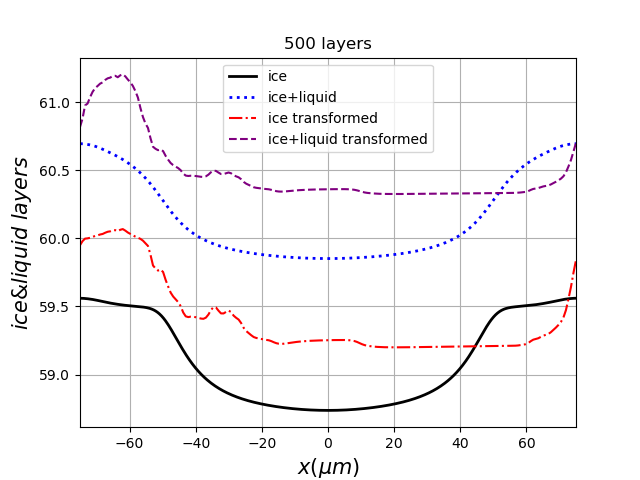

In [10]:
# Plot ice and liquid

colorIce = 'k'
colorTot = 'b'
colorSteps = 'cyan'
colorT = 'red'


plt.figure()
plt.title(str(layermax) + ' layers')

plt.plot(x-xmid, NiceFinal, color=colorIce, label='ice', lw=linewidth,linestyle='-')
plt.plot(x-xmid, NtotFinal, color=colorTot, label='ice+liquid', lw=linewidth,linestyle=':')
plt.plot(xf-xfmid, Nicekeep_ft[-1,:], color=colorT, label='ice transformed', linestyle='-.')
plt.plot(xf-xfmid, Ntotkeep_ft[-1,:], color='purple', label='ice+liquid transformed', linestyle='--')
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
# plt.ylim([0,550])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot number of steps over time
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# ff = np.max(Ntotkeep_1D) - np.min(Ntotkeep_1D)

# # f = np.max(Ntotkeep_ft,axis=1) - np.min(Ntotkeep_ft,axis=1)
# # plt.plot(tkeep_ftarr,f,lw=linewidth,color=colorSteps,linestyle=':')
# # print(Ntotkeep_1D)
# plt.plot(tkeep_1D,ff,lw=linewidth,color='b',)
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
# plt.ylabel('Number of steps',fontsize=fontsize)
# plt.grid('on')

# Plot results
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.plot(tkeep_ftarr,NQLLkeep_ft[:,0],lw=linewidth,color=colorSteps)
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
# plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
# plt.grid('on')

In [11]:
# tinterval = np.arange(0,200000,1000)

# # Message
# print("Starting a new system")
# nx = 512 # Number of points in simulation box
# xmax = 50
# x = np.linspace(0, xmax, nx)
# boxpoints = len(x)
# deltaX = x[1]-x[0]
# Nbar = 1.0 # new Nbar from VMD, 260K
# Nstar = .9/(2*np.pi)

# # Lay out the system
# nmid = int(nx/2)
# nquart = int(nx/4)
# xmid = max(x)/2
# xmax = x[nx-1]

# # Initialize as a pre-equilibrated layer of liquid over ice
# Nice0 = np.ones(boxpoints) # begin with one layer of ice
# #Adding noise to test stability of system (-Max, 6/27/2020)
# #Nice += np.random.normal(0,0.01,nx)

# NQLL0 = Nbar + Nstar * np.sin(2*np.pi*(Nice0 - Nbar)) # initialize quasi-liquid layer  
# Ntot0 = NQLL0 + Nice0



# N = 64
# xRed = np.arange(0,50,50/(2*N-2))
# sigmastepRed = ds.getsigmaI(xRed,xmax,center_reduction,sigmaIcorner)



# params = {"N" : N,
#           "Nstar" : Nstar,
#           "nu_kin" : nu_kin,
#           "deprate" : nu_kin_mlyperus,
#           "Nbar" : Nbar,
#           "sigma0" : sigma0,
#           "sigmaI" : sigmastepRed,
#           "k" : np.arange(0,N),
#           "D" : D/N,
#           "ICNT" : Ntot0,
#           "ICNQLL" : NQLL0,
#           "endtime" : tinterval[-1],
#           "timesteps" : tinterval}


# outF = runSim(params)

In [12]:
timesteps = len(outF[1])


print(timesteps)
NTotF = np.zeros((timesteps,2*N-2))
NQLLF = np.zeros((timesteps,2*N-2))

print(NTotF.shape)

for i in range(int(timesteps)):
    NTotF[i,:] = ifftnorm(outF[0:N,i])
    NQLLF[i,:] = ifftnorm(outF[N:,i])

NTotF_end = NTotF[-1,:]
NQLLF_end = NQLLF[-1,:]

NiceF_end = NTotF_end - NQLLF_end

nmidF = int((NTotF[0,:]).shape[0]/2)


# Growth statistics
minpointF = min(NiceF_end)
ncorner = 4 # why is ncorner 4 and not 0?

# total height of ice
# print("Height of Ice", minpoint)

 # change in total ice depth at each grid point
delta_Ntot_entireF = NTotF_end-NTotF[0,:]

# growth at corner and in center
# print( "1-D growth, corner", delta_Ntot_entire[ncorner])
# print( "1-D growth, center", delta_Ntot_entire[nmidF])

# growth over time (growth rate)
growthrate_entireF = delta_Ntot_entireF/outF[1,-1]*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entireF[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entireF[ncorner]/umpersec_over_mlyperus) # why different units on this one?
print( "1-D Modeled growth rate, center, um/s", growthrate_entireF[nmidF])

# alpha is some other modified growth rate
alpha = growthrate_entireF/nu_kin/sigmastepRed
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmidF])
print( "Difference, %", (alpha[nmidF]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
# alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
# print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
# print("Libbrecht's predicted alpha", alpha_L)

#########
# Plots #
#########

fignum = 0
# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
plt.figure(fignum)
plt.plot(xRed-xmid, NiceF_end, 'k', label='ice', lw=linewidth)
plt.plot(xRed-xmid, NQLLF_end+NiceF_end, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Second plot: liquid layer alone
fignum +=1
plt.figure(fignum)
plt.plot(xRed-xmid, NQLLF_end, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
plt.figure(fignum)
plt.plot(xRed-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

NameError: name 'outF' is not defined

# testing Simulation object

breaking because reached max number of layers grown.26 % 27.11 % 27.56 %29.25 %% 34.12 %% 36.1 % 36.99 % 37.24 % 37.25 % 38.51 % 38.71 % 39.72 %40.38 % % 40.64 % 40.84 % 41.1 % 41.17 %41.99 % 42.58 %44.37 % 44.53 % % 46.65 %47.18 % 47.45 % 48.17 % 48.63 %48.66 % 49.91 % 50.46 % 52.32 % 52.8 % 53.12 % 53.19 % 53.26 %53.39 % 54.05 %54.69 %% % 55.8 % 56.65 % 56.66 % 57.26 % % 58.61 % 59.98 %59.98 % 60.34 % 60.67 % 60.79 % % 61.46 % 61.59 % % 61.79 %61.92 % 61.95 % 63.0 % 63.12 % 63.18 %63.19 % 63.79 %% 64.26 % 64.29 % 64.59 %% 64.99 % 65.26 % 65.6 %65.88 % 65.99 %66.83 % 67.07 %67.12 % 67.2 %67.46 % 67.5 %%67.72 %67.86 % 67.87 % 68.0 %68.46 %68.53 %68.93 % % 70.5 % 70.53 % 70.87 % 70.98 %71.39 % 71.47 % 71.48 %71.73 %71.99 % 72.2 % 72.33 % 72.46 %% 72.51 %72.52 %72.59 % 72.68 % 72.74 % 73.08 % 73.2 %73.46 % % %73.93 %% %75.41 %75.46 % 75.47 % 75.53 % 75.66 % 75.79 % 75.8 %%76.4 %76.41 % % 76.74 % 76.86 % 76.88 % 76.99 % % 77.27 %77.47 %77.6 %% 77.94 %77.95 % % 77.99 % 78.08 %78.41 % 78.47

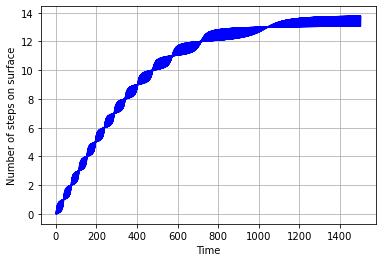

In [ ]:
# ss_1d = Simulation(ds.f1d, (501,), method='RK45')
# ss_1d.layermax = 1500

# ft_1d = 

# Ntot = ss_1d.getNtot()

# maxes = np.array([np.max(n) for n in Ntot[:]])
# mins = np.array([np.min(n) for n in Ntot[:]])


# fig,ax = plt.subplots()

# ax.plot(Ntot[:,0],maxes-mins,color='blue',label='original')

# ax.set_ylabel('Number of steps on surface')
# ax.set_xlabel('Time')

# plt.grid()
# plt.show()
